# Мультиклассификация с помощью RNN

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
plt.style.use('seaborn')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
from pathlib import Path
from skimage import transform
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
from read_data import *
from read_data import good_cols
%matplotlib inline

C:\Users\kitro\anaconda3\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [2]:
class SignalDataset(Dataset):
    def __init__(self, data_X, data_Y):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.X = data_X
        self.Y = data_Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        input_data = self.X[idx]
        label = self.Y[idx]
        
        return input_data, label

In [3]:
all_df = get_df()

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:38<00:00,  4.24s/it]


### Выбираем длину

In [4]:
TARGET_LEN = 20000
activities = sep_by_len(all_df, TARGET_LEN)
activities.shape

(64, 32)

In [262]:
CUT_LEN = 50
cut_df = cut_act(activities, CUT_LEN, count=10, random_start=True)
cut_df.sample()

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 64.49it/s]


,activityID,heart rate,temperature hand,3Da_x scale_16 hand,3Da_y scale_16 hand,3Da_z scale_16 hand,3Dg_x hand,3Dg_y hand,3Dg_z hand,3Dm_x hand,...,temperature ankle,3Da_x scale_16 ankle,3Da_y scale_16 ankle,3Da_z scale_16 ankle,3Dg_x ankle,3Dg_y ankle,3Dg_z ankle,3Dm_x ankle,3Dm_y ankle,3Dm_z ankle
389,6,"[114.0, 114.0, 114.0, 114.0, 114.0, 114.0, 114...","[34.625, 34.625, 34.625, 34.625, 34.625, 34.62...","[-4.07245, -4.03037, -4.01755, -3.86024, -3.74...","[3.25878, 3.10808, 3.60364, 3.90699, 4.02027, ...","[7.20372, 7.35881, 7.62674, 7.74354, 7.78338, ...","[0.304293, 0.28334, 0.396501, 0.437976, 0.4140...","[-0.206595, -0.178628, -0.198141, -0.187878, -...","[0.753759, 0.780291, 0.78866, 0.860559, 0.8924...","[18.2428, 17.8682, 17.7437, 17.3847, 16.6335, ...",...,"[34.4375, 34.4375, 34.4375, 34.4375, 34.4375, ...","[8.94234, 8.47551, 8.31678, 8.60389, 8.55929, ...","[-0.421969, -0.22382, 0.160027, 0.123695, -0.4...","[-1.85134, -2.51337, -2.90328, -3.3246, -3.476...","[-1.37554, -1.14273, -0.965415, -0.787605, -0....","[0.37964, 0.311473, 0.186037, 0.154918, 0.0605...","[0.468286, 0.423358, 0.384049, 0.35114, 0.2898...","[-24.7675, -23.6241, -24.2612, -24.3784, -24.1...","[5.26014, 5.71935, 5.23363, 5.11283, 5.35546, ...","[19.8951, 20.324, 19.4714, 20.1803, 19.188, 19..."


### Получаем признаки

In [263]:
X = cut_df.iloc[:, 1:].values

Y = cut_df.iloc[:, 0] # целевая переменная
X.shape, Y.shape

((640, 31), (640,))

In [264]:
y_targ = y_encode(Y)
np.unique(y_targ)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

### Нормализация

In [265]:
X_norm = normalize_dif_len(X)
X_norm.shape

(50, 640, 31)

### Приводим к одной длине

In [104]:
def get_equal_len(X, need_len=-1, fill_with=0): # Доделать
    '''
    By default sets all signals to len of signal with maximum length, putting fill_with to the end of signal
    If you know precise len you need, it can be changed, signals with bigger lenght would be cutted
    '''
    if need_len == -1:
        max_len = -1
        for sig_arr in X.T[0]:
            max_len = max(max_len, len(sig_arr))
        
        X_eq = []    
        for sig in X:
            sig_arr = np.array(list(sig), dtype=np.float64)
#             print(sig_arr.shape, max_len)
            z = np.zeros((sig_arr.shape[0], max_len-sig_arr.shape[1]), dtype=np.float64)
            new_arr = np.concatenate((sig_arr,z), axis=1)
#             print(new_arr.shape, max_len)
            X_eq.append(new_arr)
        return np.array(X_eq, dtype = np.float64)
        
    else: # Пока не сделано
        pass

In [295]:
X_eq = np.transpose(get_equal_len(X_norm), axes = [0,2,1])
X_eq.shape

(100, 100, 960)

Вариант для малой длины

In [266]:
X_eq = np.transpose(np.array(X_norm,dtype=np.float64), axes = [1,0,2])
X_eq.shape

(640, 50, 31)

In [267]:
X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor = \
    train_test_split(torch.FloatTensor(X_eq), torch.LongTensor(y_targ), random_state=42, test_size = 0.2)
X_train_tensor.shape, y_train_tensor.shape, np.unique(y_train_tensor), np.unique(y_val_tensor)

(torch.Size([512, 50, 31]),
 torch.Size([512]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64))

In [268]:
BATCH_SIZE = 64

trainset = SignalDataset(X_train_tensor, y_train_tensor)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=0)

testset = SignalDataset(X_val_tensor, y_val_tensor)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=0)
len(trainset)

512

## Подготовка модели

In [269]:
activation = nn.LeakyReLU

class RNN(nn.Module):
    def __init__(self, input_size, hidden_dim, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_size, hidden_dim, num_layers, batch_first=True, bidirectional=True, dropout=0.2)
        self.fc = nn.Linear(hidden_dim*2,num_classes)
#         self.rnn = nn.RNN(input_size = 31, hidden_size = 128, num_layers=1, batch_first = True, bidirectional = False, dropout=0)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim)
        
        out, _ = self.rnn(x, (h0, c0))
#         out = out.reshape(out.shape[0], -1) # Если хотим выход через последний слой
        out = out[:,-1,:] # Если хотим видеть в выходе все слои
        out = self.fc(out)
        return out
    
input_size = 31
hidden_dim = 32
num_layers = 4
num_classes = len(np.unique(y_targ))
# seq_len = X_signal.shape[1]

net = RNN(input_size, hidden_dim, num_layers, num_classes)

## Обучение

In [270]:
NUM_EPOCHS = 20

loss_fn = torch.nn.CrossEntropyLoss(size_average=False)
losses = []
val_losses = []

learning_rate = 3e-3
optimizer = torch.optim.AdamW(net.parameters(), lr=learning_rate)
ebar = tqdm(range(NUM_EPOCHS))

for epoch_num in ebar:
    running_loss = 0.0
    iter_num = 0
#     pbar = tqdm(enumerate(trainloader), total = len(trainloader))
    pbar = enumerate(trainloader)
    for iter_num, (X_batch, y_batch) in pbar:
        iter_num +=1
        
        y_pred = net(X_batch)
        
        loss = loss_fn(y_pred, y_batch)
        running_loss += loss.item()
                     
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        
    line = '[{}/{}] current loss: {}'.format(epoch_num+1, NUM_EPOCHS, running_loss/len(trainset))
    ebar.set_description(line)
    
    losses.append(running_loss/len(trainset))
        
    with torch.no_grad():
        y_pred = torch.softmax(net(X_val_tensor), 1)
        y = torch.argmax(y_pred, axis=1)
#         line = '[{}/{}] current valid score: {}'.format(epoch_num+1, NUM_EPOCHS, f1_score(y_val_tensor, y, average='macro'))
#         print(line)
        val_losses.append(f1_score(y_val_tensor, y, average='macro'))

C:\Users\kitro\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
[20/20] current loss: 0.6424070708453655: 100%|████████████████████████████████████████| 20/20 [00:24<00:00,  1.25s/it]


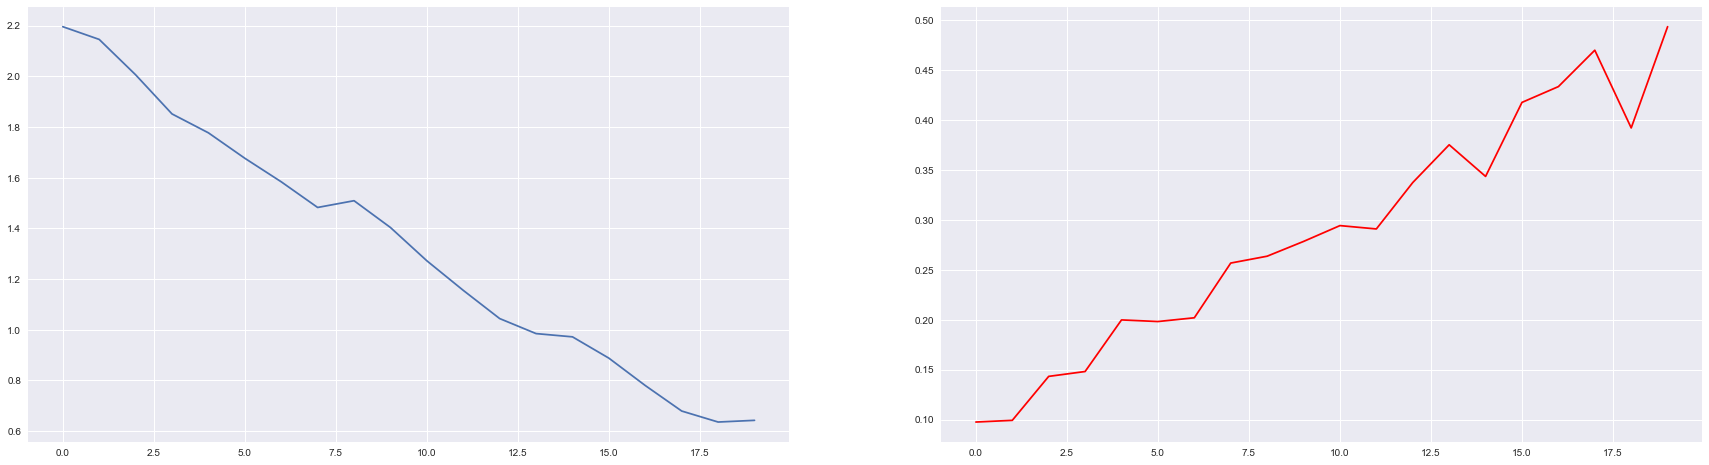

In [271]:
fig, axs = plt.subplots(1,2,figsize=(30,8))
axs[0].plot(np.arange(NUM_EPOCHS), losses)
axs[1].plot(np.arange(NUM_EPOCHS), val_losses, color='red')
plt.show()

### Оценка точности

In [272]:
for i in range(len(np.unique(y_val_tensor))):
    idx = np.argwhere(y_val_tensor==i)[0]
    y_pred = torch.sigmoid(net(X_val_tensor[idx]))
    y = torch.argmax(y_pred, axis=1)
    print(np.unique(Y)[i], len(y[y==i])/len(idx))

1 0.6666666666666666
2 0.6666666666666666
3 0.4117647058823529
4 0.5
5 0.0
6 0.6153846153846154
7 0.8
16 0.21052631578947367
17 0.42857142857142855


In [273]:
with torch.no_grad():
    y_pred = torch.softmax(net(X_val_tensor), 1)
    y = torch.argmax(y_pred, axis=1)
#     print(net(X_val_tensor).shape)
    print(roc_auc_score(y_val_tensor, y_pred, multi_class='ovo'))
    print(f1_score(y_val_tensor, y, average='macro'))

0.8568955266917083
0.4850930284350785


**sig_len = 500, hidden dim = 64, bidirectional, 100 epochs, num_layers = 1**  
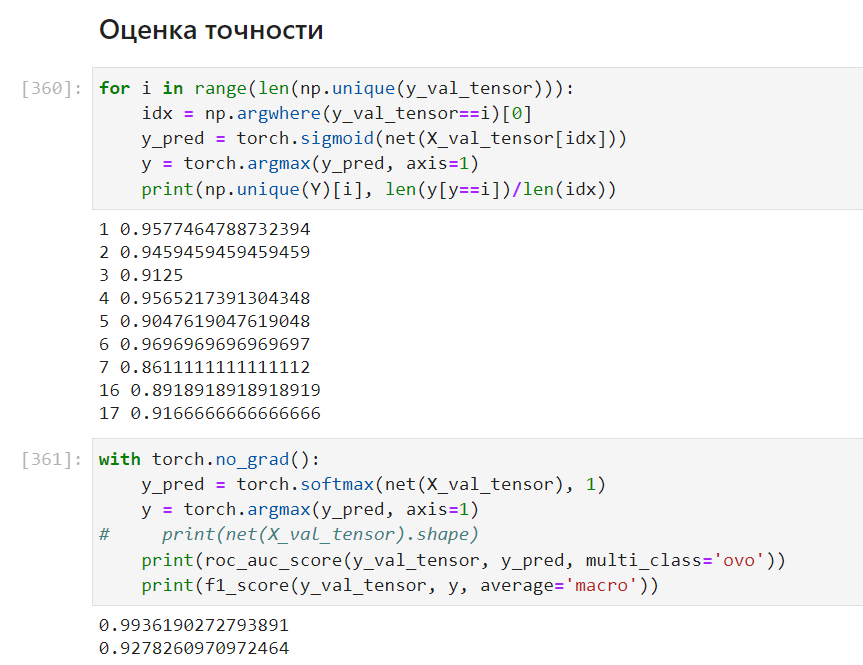

**sig_len = 100, hidden dim = 128, bidirectional, 10 epochs, num_layers = 3**  
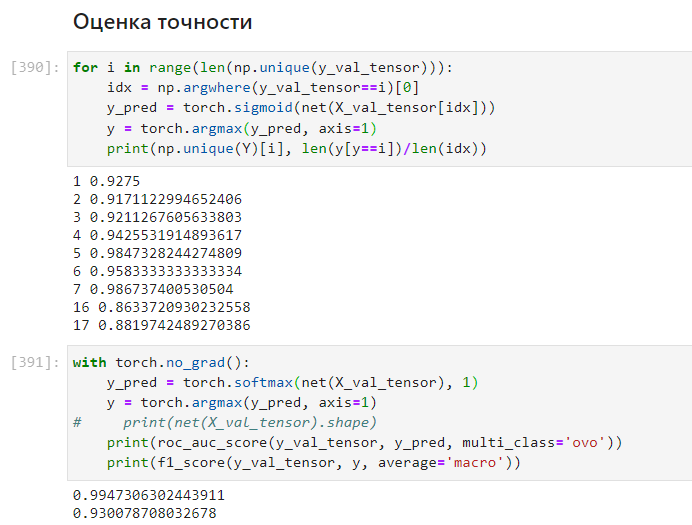

**sig_len = 100, hidden dim = 64, bidirectional, 20 epochs, num_layers = 2, dropout = 0.2**  
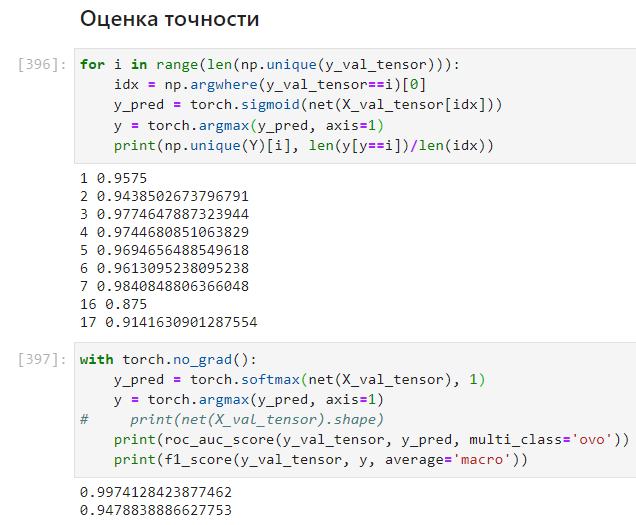

**sig_len = 100, hidden dim = 128, bidirectional, 20 epochs, num_layers = 3, dropout = 0.5**  
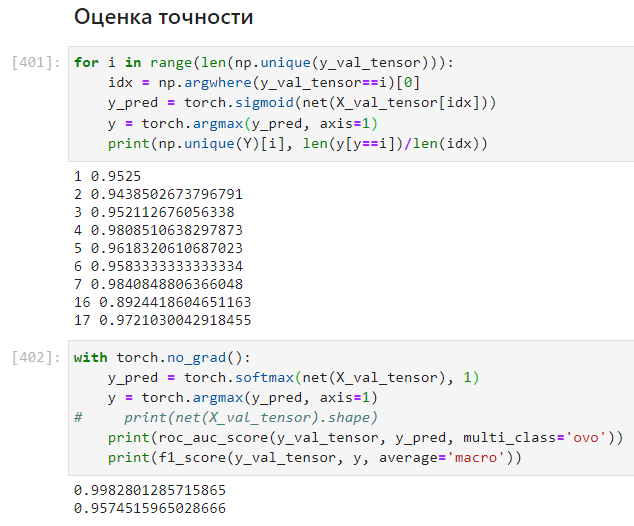